In [2]:
addprocs(15);

In [1]:
workers()

1-element Array{Int64,1}:
 1

Load required modules

In [3]:
@everywhere using QR, HD

In [4]:
@everywhere using HDF5, JLD  # loading data

In [5]:
@everywhere using PyPlot  # plotting
@everywhere using Distributions

INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...
INFO: Loading help data...


In [6]:
@everywhere function compute_coverage_refit_known_f(
    lambdaQRArr, lambdaLassoArr, tauArr, rep, indTau, indJ;
    simPath = "/scratch/midway/mkolar/qr", 
    corType = 1,
    noiseType = 1
    )    
    
    tau = tauArr[indTau]
    err_d = Normal()
    spF = 1. / pdf(err_d, 0 )
    
    # load data
    data = JLD.load("$(simPath)/data/data_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
    X = data["X"]
    Y = data["Y"]
    s = data["s"]
    true_beta = data["beta"]
    
    if indJ > s
        true_coef = 0.
    else
        true_coef = true_beta[indJ]
    end
    
    n, p = size(X)
    
    hSigma = X'*X / n
    
    residuals = Array(Float64, n)
    gradient = Array(Float64, p)
    
    num_covered = zeros(length(lambdaQRArr), length(lambdaLassoArr))
    num_appear = zeros(length(lambdaQRArr), length(lambdaLassoArr))
    
    # load result rep --> result
    if isfile("$(simPath)/path_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
        result = JLD.load("$(simPath)/path_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
    else
        return (num_appear, num_covered)
    end
        
    cur_qr_path = result["qr_tau_path"][indTau]
    cur_lasso_path = result["lasso_var_path"][indJ]

    for indL1=1:length(cur_qr_path.lambdaArr)        
        estim_support_qr = find(cur_qr_path.beta[indL1])
        refit_qr = result["qr_refit_tau_path"][indTau][estim_support_qr]
        
        for indL2=1:length(cur_lasso_path.lambdaArr)
            estim_support_lasso = find(cur_lasso_path.beta[indL2])
            refit_lasso = result["lasso_refit_var_path"][indJ][estim_support_lasso]

            for i=1:n
                tmp = Y[i] - refit_qr.intercept - dot(vec(X[i, refit_qr.beta.rowval]), refit_qr.beta.nzval)
                if tmp < 0.
                    residuals[i] = tau - 1
                else
                    residuals[i] = tau
                end
            end
            At_mul_B!(gradient, X, residuals)              
            
            hb_debias = refit_qr.beta[indJ] + dot(refit_lasso, gradient[estim_support_lasso]) * spF / n
            eSigma = dot(refit_lasso, hSigma[estim_support_lasso, estim_support_lasso] * refit_lasso) * tau * (1 - tau) * spF^2 / n
            lb = hb_debias - 1.96 * sqrt( eSigma )
            ub = hb_debias + 1.96 * sqrt( eSigma )            
            
            num_appear[indL1, indL2] += 1
            if (lb < true_coef < ub)
                num_covered[indL1, indL2] += 1
            end
            
        end
    end
    
    (num_covered, num_appear)
end

## Computing coverage

In [7]:
@everywhere function loadF(rep) 
    lambdaQRArr = linspace(0.4, 0.0, 100)
    lambdaLassoArr = linspace(0.8, 0.05, 100)
    tauArr = [0.3:0.02:0.7]
    indTau = findfirst(tauArr,0.5)
    indJ = 10
    
    simPath = "/scratch/midway/mkolar/qr1"    
    corType = 2
    noiseType = 1
    
    @time compute_coverage_refit_known_f(
        lambdaQRArr, lambdaLassoArr, tauArr, rep, indTau, indJ;
        simPath = simPath, 
        corType = corType,
        noiseType = noiseType)    
end

In [8]:
numRep = 1
colRes = pmap(loadF, [1:numRep]);

	From worker 2:	elapsed time: 0.681117518 seconds (15596996 bytes allocated)
	From worker 2:	elapsed time: 2.207007371 seconds (67838328 bytes allocated, 2.40% gc time)
	From worker 2:	elapsed time: 12.942175245 seconds (3227094128 bytes allocated, 22.56% gc time)


In [ ]:
numRep = 500

agr_num_covered = zeros(100, 100)
agr_num_appear = zeros(100, 100)

for j=1:numRep
    agr_num_covered += colRes[j][1]
    agr_num_appear += colRes[j][2]
end

tmp = agr_num_covered ./ agr_num_appear
@show tmp[80:90,70:90]
imshow(tmp)
colorbar()

LoadError: PyError (:PyObject_Call) <type 'exceptions.RuntimeError'>
RuntimeError(u'No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).',)
  File "/home/mkolar/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py", line 2147, in colorbar
    raise RuntimeError('No mappable was found to use for colorbar '

while loading In[72], in expression starting on line 1

Kill Workers

In [ ]:
rmprocs(workers())

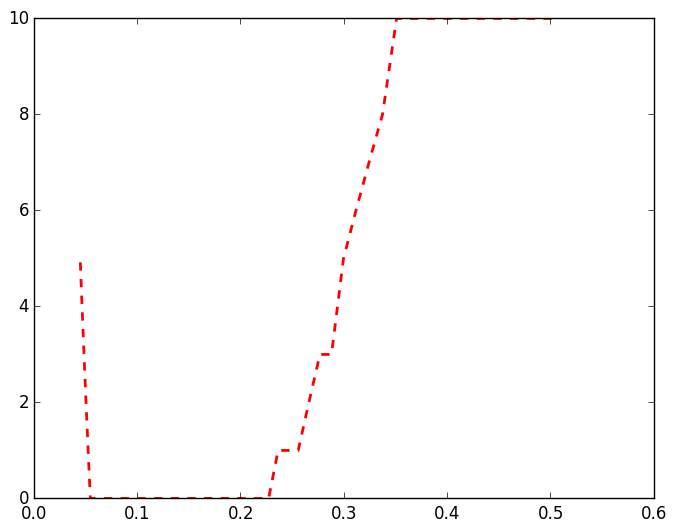

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fb396a4a450>

In [105]:
h_dist = zeros(100)
num_exp = zeros(100)
s = 10
numRep = 90
for rep=1:numRep
    cur_qr_path = simRes[1]["qr_tau_path"][indTau]
    for indLambda=1:length(cur_qr_path.lambdaArr)
        estim_support = find(cur_qr_path.beta[indLambda])
        h_dist[indLambda] += length(setdiff(1:s, estim_support)) + length(setdiff(estim_support, 1:s))
        num_exp[indLambda] += 1
    end    
end

plot(lambdaArr, h_dist ./ num_exp, color="red", linewidth=2.0, linestyle="--")

## For Debugging

In [9]:
simPath = "/scratch/midway/mkolar/qr1"
rep = 1
corType = 2
noiseType = 1

lambdaQRArr = linspace(0.4, 0.0, 100)
lambdaLassoArr = linspace(0.8, 0.05, 100)
tauArr = [0.3:0.02:0.7]
indTau = findfirst(tauArr,0.5)
indJ = 10


data = JLD.load("$(simPath)/data/data_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld")
X = data["X"]
Y = data["Y"]
s = data["s"]
true_beta = data["beta"]

tau = 0.5
err_d = Normal()
spF = 1. / pdf(err_d, 0 )

n, p = size(X)

result = JLD.load("$(simPath)/path_rep_$(rep)_cor_$(corType)_noise_$(noiseType).jld");

In [11]:
hSigma = X'*X / n

residuals = Array(Float64, n)
g = Array(Float64, p)

num_covered = zeros(length(lambdaQRArr), length(lambdaLassoArr))
num_appear = zeros(length(lambdaQRArr), length(lambdaLassoArr))

cur_qr_path = result["qr_tau_path"][indTau]
cur_lasso_path = result["lasso_var_path"][indJ];

In [22]:
@show lambdaQRArr[95]
cur_qr_path.beta[95]

lambdaQRArr[95] => 0.020202020202020204


100x1 sparse matrix with 16 Float64 entries:
	[1  ,   1]  =  0.919943
	[2  ,   1]  =  0.981416
	[3  ,   1]  =  0.739849
	[4  ,   1]  =  0.608789
	[5  ,   1]  =  0.505494
	[22 ,   1]  =  -0.0235629
	[24 ,   1]  =  -0.00940574
	[35 ,   1]  =  -0.0119907
	[49 ,   1]  =  0.00966997
	[57 ,   1]  =  -0.00361409
	[58 ,   1]  =  -0.0144407
	[72 ,   1]  =  0.0126296
	[76 ,   1]  =  0.00595938
	[79 ,   1]  =  0.0269848
	[83 ,   1]  =  -0.0172218
	[90 ,   1]  =  -0.00814166

In [42]:
estim_support_lasso = find(cur_lasso_path.beta[indL2])
refit_lasso = result["lasso_refit_var_path"][indJ][estim_support_lasso]

2-element Array{Float64,1}:
  2.78076
 -2.16707

In [43]:
for i=1:n
    tmp = Y[i] - refit_qr.intercept - dot(vec(X[i, refit_qr.beta.rowval]), refit_qr.beta.nzval)
    if tmp < 0.
        residuals[i] = tau - 1
    else
        residuals[i] = tau
    end
end
At_mul_B!(g, X, residuals)    

hb_debias = refit_qr.beta[indJ] + dot(refit_lasso, g[estim_support_lasso]) * spF / n

0.9828877467764753

In [53]:
refit_lasso' * g[estim_support_lasso] * spF / n

1-element Array{Float64,1}:
 -0.00286327

In [54]:
eSigma = dot(refit_lasso, hSigma[estim_support_lasso, estim_support_lasso] * refit_lasso) * tau * (1 - tau) * spF^2 / n

0.004368003917468316

In [56]:
lb = hb_debias - 1.96 * sqrt( eSigma )
ub = hb_debias + 1.96 * sqrt( eSigma )
lb, ub

(0.8533496294158069,1.1124258641371436)

In [39]:


for indL1=1:length(cur_qr_path.lambdaArr)
    estim_support_qr = find(cur_qr_path.beta[indL1])
    refit_qr = result["qr_refit_tau_path"][indTau][estim_support_qr]

    for indL2=1:length(cur_lasso_path.lambdaArr)
        estim_support_lasso = find(cur_lasso_path.beta[indL2])
        refit_lasso = result["lasso_refit_var_path"][indJ][estim_support_lasso]

        for i=1:n
            tmp = Y[i] - refit_qr.intercept - dot(vec(X[i, refit_qr.beta.rowval]), refit_qr.beta.nzval)
            if tmp < 0.
                residuals[i] = tau - 1
            else
                residuals[i] = tau
            end
        end
        At_mul_B!(g, X, residuals)              

        hb_debias = refit_qr.beta[indJ] + dot(refit_lasso, g[estim_support_lasso]) * spF / n
        eSigma = dot(refit_lasso, hSigma[estim_support_lasso, estim_support_lasso] * refit_lasso) * tau * (1 - tau) * spF^2    
        lb = hb_debias - 1.96 * sqrt( eSigma )
        ub = hb_debias + 1.96 * sqrt( eSigma )

        num_appear[indL1, indL2] += 1
        if (lb < true_beta[indJ] < ub)
            num_covered[indL1, indL2] += 1
        end

    end
end